# AlexNet from scratch in PyTorch
This project is our series of building most popular convolutional neural networks (CNN) **from scratch in PyTorch**.

Here, we builded **`AlexNet`** architecture for CIFAR Dataset, which is one of the most popular algorithm in Computer Vision. 

## AlexNet

`AlexNet` is a sophisticated convolutional neural network created by `Alex Krizhevsky and a team of researchers` in 2012. Its primary purpose was to categorize images for the ImageNet LSVRC-2010 competition, where it demonstrated outstanding performance. You can find an extensive explanation of the model in the original research paper: [`"ImageNet Classification with Deep Convolutional Neural Networks"`](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf?ref=blog.paperspace.com)

## About Dataset
Let's start by loading and then pre-processing the data. We will be using the **`CIFAR10 dataset`** due-to Alexnet original dataset is **dreadfully large (138GB!)**. Of course, it needs large computation resourses. The dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 
There are 50000 training images and 10000 test images.

Here are the classes in the dataset, as well as 10 random sample images from each:
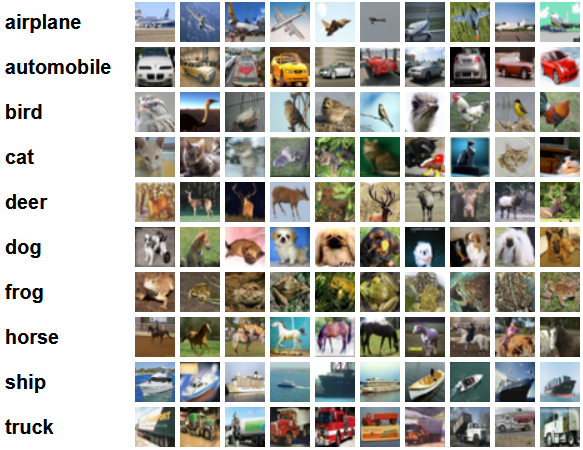
<!-- ![CIFAR Dataset Example](images/cifar.png) -->
<!-- <img src="https://www.google.com/url?sa=i&url=https%3A%2F%2Fpaperswithcode.com%2Fdataset%2Fcifar-10&psig=AOvVaw2fkpQr-DpfhT6eAxVAAKSk&ust=1699457446771000&source=images&cd=vfe&opi=89978449&ved=0CBIQjRxqFwoTCKDnxL2asoIDFQAAAAAdAAAAABAE" alt="CIFAR Dataset Example" /> -->


*Source: https://www.cs.toronto.edu/%7Ekriz/cifar.html*

## Importing the libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

torch.__version__

'2.3.0+cu121'

In [2]:
# set device as an agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
device_name = torch.cuda.get_device_name()
device_name  # used 1 gpu

'NVIDIA GeForce RTX 4070'

## Loading the Dataset

### Load the `torchvision.datasets.CIFAR10()` train and test datasets.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
train_data = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform,
    target_transform=None
)

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform,
    target_transform=None,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
image, label = train_data[0]
image, label

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [7]:
# Check out the shapes of data
print(f'Image shape: {image.shape} -> [color_channels, height, width] (CHW)')
print(f'Label : {label} -> no shape, due to being integer')

Image shape: torch.Size([3, 32, 32]) -> [color_channels, height, width] (CHW)
Label : 6 -> no shape, due to being integer


**Note:** There are two main agreed upon ways for representing images in machine learning:
1. Color channels first: [color_channels, height, width] **`(CHW) -> PyTorch`** default
2. Color channels last: [height, width, color_channels] **`(HWC) -> Matplotlib/TensorFlow`** default

In [8]:
class_names = train_data.classes
class_names  # 10 classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
# checking the length of the data
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [10]:
# Divide train_data to train and validation
from torch.utils.data import random_split
generator1 = torch.Generator().manual_seed(42)

train_size = int(0.8 * len(train_data))  # 80% for train
val_size = len(train_data) - train_size  # 20% for validation
train_data, validation_data = random_split(train_data, [train_size, val_size], generator=generator1)  # generator for fix seed

In [11]:
len(train_data), len(test_data), len(validation_data)

(40000, 10000, 10000)

In [12]:
img, label = validation_data[0]
img.shape, label

(torch.Size([3, 32, 32]), 7)

### Visualize some samples of CIFAR training dataset

In [13]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i in range(5):
    img, label = train_data[i]  # and we can use like: img = train_data[i][0], label = train_data[i][1]
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)  # and we can use class_name title: class_names[label]
    plt.axis(False)  # delete axis values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Prepare dataloader

used `torch.utils.data.DataLoader`

In [14]:
from torch.utils.data import DataLoader

# Setup batch size
BATCH_SIZE = 1024

# Set the seed for reproducibility
torch.manual_seed(42)

# Turn the CIFAR dataset into dataloaders (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

validation_dataloader = DataLoader(dataset=validation_data,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False)

# let's check our dataloader
print(f'Dataloaders: {train_dataloader, test_dataloader, validation_dataloader}')
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')  # len(train_dataloader) = 50000 / 32 = 1250
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')  # len(train_dataloader) = 10000 / 32 = 313
print(f'Length of validation dataloader: {len(validation_dataloader)} batches of {BATCH_SIZE}')  # len(train_dataloader) = 10000 / 32 = 313

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x73891d9aded0>, <torch.utils.data.dataloader.DataLoader object at 0x73892429e9b0>, <torch.utils.data.dataloader.DataLoader object at 0x73891d9ae530>)
Length of train dataloader: 40 batches of 1024
Length of test dataloader: 10 batches of 1024
Length of validation dataloader: 10 batches of 1024


In [15]:
# Getting the next batch of data and labels from the training loader
train_features_batch, train_label_batch = next(iter(train_dataloader))  

# print the shape of a batch of data and labels
train_features_batch.shape, train_label_batch.shape  # 32 batches of data and 32 labels

(torch.Size([1024, 3, 32, 32]), torch.Size([1024]))

## About architecture
We are doing for CIFAR dataset, thefore it should be changed in first Conv2D(stride = 4), because CIFAR image has 32x32, which is significant lower than original image of ImageNet's dataset.  Maxpool stride to 1 ==> stride = 1, except last one

In [16]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=1), # [batch, 96, 22, 22]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),  # [batch, 96, 20, 20]
            nn.BatchNorm2d(96),
        
            nn.Conv2d(96, 256, 5, padding=2),  # [batch, 256, 20, 20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),  # [batch, 256, 18, 18]
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 384, 3, padding=1),  # [batch, 384, 18, 18]
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # [batch, 384, 18, 18]
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # [batch, 256, 18, 18]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # [batch, 256, 8, 8]
            nn.BatchNorm2d(256)
        )
        # classifier (linear layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*8*8, out_features=4096),
            nn.ReLU(),
            nn.Dropout(),  # default p = 0.5
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes)  # num_classes = 10 (CIFAR images)
        )

    def forward(self, x):
            """
            Pass the input through the net.

            Args:
                x (Tensor): input tensor

            Returns:
                output (Tensor): output tensor
            """
            x = self.net(x)
            #print(f"Output shape through net layer:  {x.shape}")
            return self.classifier(x)


### Create model AlexNet on GPU

In [17]:
torch.manual_seed(45)

model_gpu = AlexNet().to(device)
model_gpu

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

### Checking number of parameters 

In [18]:
total = 0
print('Trainable parameters:')
for name, param in model_gpu.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
net.0.weight 	 34848
net.0.bias 	 96
net.3.weight 	 96
net.3.bias 	 96
net.4.weight 	 614400
net.4.bias 	 256
net.7.weight 	 256
net.7.bias 	 256
net.8.weight 	 884736
net.8.bias 	 384
net.10.weight 	 1327104
net.10.bias 	 384
net.12.weight 	 884736
net.12.bias 	 256
net.15.weight 	 256
net.15.bias 	 256
classifier.1.weight 	 67108864
classifier.1.bias 	 4096
classifier.4.weight 	 16777216
classifier.4.bias 	 4096
classifier.7.weight 	 40960
classifier.7.bias 	 10

Total 	 87683658


In [19]:
next(model_gpu.parameters()).device  # check model device

device(type='cuda', index=0)

## Training model

In [20]:
# Set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

In [21]:
# Setup metrics
from torchmetrics import Accuracy
from tqdm.auto import tqdm

# set seed
torch.manual_seed(42)

acc_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Setup training/validation loop
epochs = 50
for epoch in tqdm(range(epochs)):
    train_loss, val_loss_total = 0, 0
    train_acc, val_acc = 0, 0

    ### Training
    model_gpu.train()
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        # make sure data on right device
        X_train, y_train = X_train.to(device), y_train.to(device)

        # forward prop
        y_pred = model_gpu(X_train)

        # loss and accuracy
        loss = loss_fn(y_pred, y_train)
        train_loss += loss

        train_acc += acc_fn(y_pred, y_train)

        # Zero paramater grad 
        optimizer.zero_grad()
        # Backprop and grad. desc.
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    ### Validation
    # Turn on eval mode
    model_gpu.eval()

    # Turn inference mode
    with torch.inference_mode():
        for batch, (X_val, y_val) in enumerate(validation_dataloader):
            X_val, y_val = X_val.to(device), y_val.to(device)

            # Forward prop, calc loss and acc
            y_val_pred = model_gpu(X_val)
            val_loss = loss_fn(y_val_pred, y_val)
            val_loss_total += val_loss

            val_acc += acc_fn(y_val_pred, y_val)

        # val loss and acc per epoch
        val_loss_total /= len(validation_dataloader)
        val_acc /= len(validation_dataloader)
        val_losses.append(val_loss_total)
        val_accs.append(val_acc)

    # print what's happening
    print(f'Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Val loss: {val_loss_total:.3f} | Val acc: {val_acc:.2f}')



/home/aksultan/Downloads/Distributed_Training/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  2%|▏         | 1/50 [00:18<14:45, 18.07s/it]

Epoch: 0 | Train loss: 2.180 | Train acc: 0.21 | Val loss: 2.128 | Val acc: 0.30


  4%|▍         | 2/50 [00:35<14:19, 17.91s/it]

Epoch: 1 | Train loss: 1.849 | Train acc: 0.33 | Val loss: 1.708 | Val acc: 0.39


  6%|▌         | 3/50 [00:53<13:59, 17.87s/it]

Epoch: 2 | Train loss: 1.658 | Train acc: 0.39 | Val loss: 1.549 | Val acc: 0.44


  8%|▊         | 4/50 [01:11<13:41, 17.86s/it]

Epoch: 3 | Train loss: 1.518 | Train acc: 0.44 | Val loss: 1.440 | Val acc: 0.48


 10%|█         | 5/50 [01:29<13:22, 17.83s/it]

Epoch: 4 | Train loss: 1.410 | Train acc: 0.49 | Val loss: 1.344 | Val acc: 0.52


 12%|█▏        | 6/50 [01:47<13:02, 17.79s/it]

Epoch: 5 | Train loss: 1.326 | Train acc: 0.52 | Val loss: 1.262 | Val acc: 0.54


 14%|█▍        | 7/50 [02:04<12:43, 17.75s/it]

Epoch: 6 | Train loss: 1.249 | Train acc: 0.55 | Val loss: 1.215 | Val acc: 0.57


 16%|█▌        | 8/50 [02:22<12:27, 17.79s/it]

Epoch: 7 | Train loss: 1.171 | Train acc: 0.58 | Val loss: 1.167 | Val acc: 0.58


 18%|█▊        | 9/50 [02:40<12:08, 17.77s/it]

Epoch: 8 | Train loss: 1.121 | Train acc: 0.60 | Val loss: 1.131 | Val acc: 0.60


 20%|██        | 10/50 [02:58<11:51, 17.78s/it]

Epoch: 9 | Train loss: 1.064 | Train acc: 0.62 | Val loss: 1.135 | Val acc: 0.59


 22%|██▏       | 11/50 [03:15<11:34, 17.81s/it]

Epoch: 10 | Train loss: 1.029 | Train acc: 0.63 | Val loss: 1.037 | Val acc: 0.63


 24%|██▍       | 12/50 [03:33<11:17, 17.83s/it]

Epoch: 11 | Train loss: 0.968 | Train acc: 0.66 | Val loss: 1.063 | Val acc: 0.62


 26%|██▌       | 13/50 [03:51<11:00, 17.85s/it]

Epoch: 12 | Train loss: 0.950 | Train acc: 0.66 | Val loss: 1.054 | Val acc: 0.62


 28%|██▊       | 14/50 [04:09<10:43, 17.88s/it]

Epoch: 13 | Train loss: 0.903 | Train acc: 0.68 | Val loss: 1.060 | Val acc: 0.63


 30%|███       | 15/50 [04:27<10:25, 17.88s/it]

Epoch: 14 | Train loss: 0.878 | Train acc: 0.69 | Val loss: 1.036 | Val acc: 0.64


 32%|███▏      | 16/50 [04:45<10:07, 17.88s/it]

Epoch: 15 | Train loss: 0.841 | Train acc: 0.70 | Val loss: 0.974 | Val acc: 0.66


 34%|███▍      | 17/50 [05:03<09:50, 17.89s/it]

Epoch: 16 | Train loss: 0.810 | Train acc: 0.72 | Val loss: 0.933 | Val acc: 0.67


 36%|███▌      | 18/50 [05:21<09:32, 17.89s/it]

Epoch: 17 | Train loss: 0.768 | Train acc: 0.73 | Val loss: 0.915 | Val acc: 0.68


 38%|███▊      | 19/50 [05:39<09:14, 17.88s/it]

Epoch: 18 | Train loss: 0.734 | Train acc: 0.74 | Val loss: 0.925 | Val acc: 0.68


 40%|████      | 20/50 [05:56<08:54, 17.83s/it]

Epoch: 19 | Train loss: 0.707 | Train acc: 0.75 | Val loss: 0.934 | Val acc: 0.68


 42%|████▏     | 21/50 [06:14<08:35, 17.78s/it]

Epoch: 20 | Train loss: 0.672 | Train acc: 0.77 | Val loss: 0.915 | Val acc: 0.69


 44%|████▍     | 22/50 [06:32<08:17, 17.76s/it]

Epoch: 21 | Train loss: 0.650 | Train acc: 0.77 | Val loss: 0.989 | Val acc: 0.67


 46%|████▌     | 23/50 [06:49<07:58, 17.74s/it]

Epoch: 22 | Train loss: 0.609 | Train acc: 0.79 | Val loss: 0.932 | Val acc: 0.68


 48%|████▊     | 24/50 [07:07<07:41, 17.76s/it]

Epoch: 23 | Train loss: 0.590 | Train acc: 0.80 | Val loss: 0.915 | Val acc: 0.70


 50%|█████     | 25/50 [07:25<07:24, 17.78s/it]

Epoch: 24 | Train loss: 0.570 | Train acc: 0.80 | Val loss: 0.866 | Val acc: 0.71


 52%|█████▏    | 26/50 [07:43<07:07, 17.82s/it]

Epoch: 25 | Train loss: 0.523 | Train acc: 0.82 | Val loss: 0.910 | Val acc: 0.70


 54%|█████▍    | 27/50 [08:01<06:50, 17.84s/it]

Epoch: 26 | Train loss: 0.517 | Train acc: 0.82 | Val loss: 0.921 | Val acc: 0.69


 56%|█████▌    | 28/50 [08:19<06:32, 17.85s/it]

Epoch: 27 | Train loss: 0.491 | Train acc: 0.83 | Val loss: 0.864 | Val acc: 0.71


 58%|█████▊    | 29/50 [08:36<06:14, 17.82s/it]

Epoch: 28 | Train loss: 0.455 | Train acc: 0.84 | Val loss: 1.044 | Val acc: 0.67


 60%|██████    | 30/50 [08:54<05:55, 17.80s/it]

Epoch: 29 | Train loss: 0.443 | Train acc: 0.85 | Val loss: 0.888 | Val acc: 0.71


 62%|██████▏   | 31/50 [09:11<05:32, 17.52s/it]

Epoch: 30 | Train loss: 0.405 | Train acc: 0.87 | Val loss: 0.944 | Val acc: 0.70


 64%|██████▍   | 32/50 [09:28<05:11, 17.28s/it]

Epoch: 31 | Train loss: 0.375 | Train acc: 0.88 | Val loss: 0.940 | Val acc: 0.70


 66%|██████▌   | 33/50 [09:44<04:50, 17.11s/it]

Epoch: 32 | Train loss: 0.348 | Train acc: 0.88 | Val loss: 1.009 | Val acc: 0.69


 68%|██████▊   | 34/50 [10:01<04:31, 17.00s/it]

Epoch: 33 | Train loss: 0.339 | Train acc: 0.89 | Val loss: 1.074 | Val acc: 0.68


 70%|███████   | 35/50 [10:18<04:13, 16.91s/it]

Epoch: 34 | Train loss: 0.308 | Train acc: 0.90 | Val loss: 0.995 | Val acc: 0.71


 72%|███████▏  | 36/50 [10:35<03:56, 16.86s/it]

Epoch: 35 | Train loss: 0.268 | Train acc: 0.91 | Val loss: 0.968 | Val acc: 0.71


 74%|███████▍  | 37/50 [10:51<03:38, 16.82s/it]

Epoch: 36 | Train loss: 0.239 | Train acc: 0.93 | Val loss: 1.012 | Val acc: 0.70


 76%|███████▌  | 38/50 [11:08<03:21, 16.78s/it]

Epoch: 37 | Train loss: 0.237 | Train acc: 0.93 | Val loss: 0.941 | Val acc: 0.72


 78%|███████▊  | 39/50 [11:25<03:04, 16.77s/it]

Epoch: 38 | Train loss: 0.213 | Train acc: 0.93 | Val loss: 0.983 | Val acc: 0.71


 80%|████████  | 40/50 [11:42<02:47, 16.76s/it]

Epoch: 39 | Train loss: 0.197 | Train acc: 0.94 | Val loss: 1.120 | Val acc: 0.69


 82%|████████▏ | 41/50 [11:58<02:30, 16.75s/it]

Epoch: 40 | Train loss: 0.222 | Train acc: 0.93 | Val loss: 1.035 | Val acc: 0.71


 84%|████████▍ | 42/50 [12:15<02:13, 16.74s/it]

Epoch: 41 | Train loss: 0.195 | Train acc: 0.94 | Val loss: 1.097 | Val acc: 0.70


 86%|████████▌ | 43/50 [12:32<01:57, 16.74s/it]

Epoch: 42 | Train loss: 0.161 | Train acc: 0.95 | Val loss: 0.999 | Val acc: 0.72


 88%|████████▊ | 44/50 [12:48<01:40, 16.74s/it]

Epoch: 43 | Train loss: 0.127 | Train acc: 0.97 | Val loss: 1.023 | Val acc: 0.72


 90%|█████████ | 45/50 [13:05<01:23, 16.73s/it]

Epoch: 44 | Train loss: 0.118 | Train acc: 0.97 | Val loss: 1.142 | Val acc: 0.71


 92%|█████████▏| 46/50 [13:22<01:06, 16.73s/it]

Epoch: 45 | Train loss: 0.131 | Train acc: 0.96 | Val loss: 1.054 | Val acc: 0.72


 94%|█████████▍| 47/50 [13:39<00:50, 16.73s/it]

Epoch: 46 | Train loss: 0.096 | Train acc: 0.97 | Val loss: 1.013 | Val acc: 0.73


 96%|█████████▌| 48/50 [13:55<00:33, 16.73s/it]

Epoch: 47 | Train loss: 0.086 | Train acc: 0.98 | Val loss: 1.120 | Val acc: 0.72


 98%|█████████▊| 49/50 [14:12<00:16, 16.72s/it]

Epoch: 48 | Train loss: 0.084 | Train acc: 0.98 | Val loss: 1.068 | Val acc: 0.72


100%|██████████| 50/50 [14:29<00:00, 17.39s/it]

Epoch: 49 | Train loss: 0.082 | Train acc: 0.98 | Val loss: 1.050 | Val acc: 0.73


Accuracy for 10 000 validation images => 73%